In [10]:
import requests
import pandas as pd
import time

API_KEY = "30c8ea0596717c63a88684285f5afe15"

_DIRECTOR_CACHE = {}

def get_director(movie_id, api_key=API_KEY):
    """Return director name for a TMDB movie id, or None if not found."""
    if not movie_id:
        return None
    if movie_id in _DIRECTOR_CACHE:
        return _DIRECTOR_CACHE[movie_id]
    try:
        url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
        params = {"api_key": api_key}
        r = requests.get(url, params=params, timeout=10)
        r.raise_for_status()
        crew = r.json().get("crew", [])
        director = next((c.get("name") for c in crew if c.get("job") == "Director"), None)
    except Exception:
        director = None
    # cache and return
    _DIRECTOR_CACHE[movie_id] = director
    # be polite to API (small delay)
    time.sleep(0.08)
    return director

def get_genre_mapping(api_key=API_KEY, language="en-US"):
    """
    Get mapping from TMDB genre IDs to genre names.
    Returns dict like {28: "Action", 12: "Adventure", ...}
    """
    url = "https://api.themoviedb.org/3/genre/movie/list"
    params = {
        "api_key": api_key,
        "language": language
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    genres = r.json().get("genres", [])
    # build dictionary id -> name
    genre_map = {g["id"]: g["name"] for g in genres}
    return genre_map

def fetch_movies_page(min_rating=0.0,
                      min_votes=1000,
                      page=1,
                      language="en-US",
                      sort_by="vote_average.desc"):
    """
    Fetch one page of movies from TMDB /discover/movie with rating filters.
    Returns parsed JSON.
    """
    url = "https://api.themoviedb.org/3/discover/movie"

    params = {
        "api_key": API_KEY,
        "language": language,
        "sort_by": sort_by,             # sort by highest rating
        "vote_average.gte": min_rating, # min rating filter
        "vote_count.gte": min_votes,    # only well-voted movies
        "page": page
    }

    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()

def collect_movies(min_rating=0.0,
                   min_votes=1000,
                   max_pages=500,
                   genre_map=None):
    """
    Loop through pages of /discover/movie,
    map genre_ids -> genre names,
    return list of dict rows.
    """
    all_movies = []

    for p in range(1, max_pages + 1):
        data = fetch_movies_page(
            min_rating=min_rating,
            min_votes=min_votes,
            page=p
        )

        results = data.get("results", [])
        if not results:
            break

        for m in results:
            # map genre_ids -> list of genre names
            genre_ids = m.get("genre_ids", [])
            if genre_map is not None:
                genre_names = [genre_map.get(gid, "UNKNOWN") for gid in genre_ids]
            else:
                genre_names = []
            
            director_name = get_director(m.get("id"))

            movie_row = {
                "id": m.get("id"),
                "title": m.get("title"),
                "original_title": m.get("original_title"),
                "release_date": m.get("release_date"),
                "vote_average": m.get("vote_average"),
                "vote_count": m.get("vote_count"),
                "popularity": m.get("popularity"),
                "original_language": m.get("original_language"),
                "overview": m.get("overview"),
                "genre_ids": genre_ids,           # keep raw IDs (optional)
                "genres": genre_names,            # human-readable genres ✅
                "director": director_name         # director name ✅
            }
            all_movies.append(movie_row)

        # be polite to TMDB
        time.sleep(0.25)

        # stop if we've reached the actual last page
        total_pages = data.get("total_pages", max_pages)
        if p >= total_pages:
            break

    return all_movies

def build_dataframe(min_rating=5.0,
                    min_votes=1000,
                    max_pages=5):
    
    genre_map = get_genre_mapping()

    movies_list = collect_movies(
        min_rating=min_rating,
        min_votes=min_votes,
        max_pages=max_pages,
        genre_map=genre_map
    )

    df = pd.DataFrame(movies_list)
    return df

if __name__ == "__main__":
    # Example usage:
    df_movies = build_dataframe(
        min_rating=0.0,    # rating >= 8.0
        min_votes=1000,    # with at least 1000 votes
        max_pages=250        # pull first 5 pages (~100 movies)
    )

    # Show first few rows with nice columns
    print(df_movies.head())
    print("Total movies collected:", len(df_movies))
    
    # Save to CSV
    df_movies.to_csv("movies_data.csv", index=False, encoding="utf-8")


    id                     title            original_title release_date  \
0  278  The Shawshank Redemption  The Shawshank Redemption   1994-09-23   
1  238             The Godfather             The Godfather   1972-03-14   
2  240     The Godfather Part II     The Godfather Part II   1974-12-20   
3  424          Schindler's List          Schindler's List   1993-12-15   
4  389              12 Angry Men              12 Angry Men   1957-04-10   

   vote_average  vote_count  popularity original_language  \
0         8.712       29138     33.6374                en   
1         8.700       22012     26.0066                en   
2         8.571       13301     13.9968                en   
3         8.567       16825     13.6492                en   
4         8.548        9498     10.6725                en   

                                            overview        genre_ids  \
0  Imprisoned in the 1940s for the double murder ...         [18, 80]   
1  Spanning the years 1945 to 1955, 

# Display basic statistics

## Distribution of movie ratings

In this section, we will analyze the distribution of movie ratings in our collected dataset. We will use pandas to compute basic statistics and visualize the distribution using matplotlib. This, will be helpful to see what average ratings are most common among the movies we have collected with 1000 or more votes. Before running the code, we expect to see a heavy weighting towards a rating of 7, due to the folk wisdom that "People go to IMDb (or similar) to rate everything a seven".

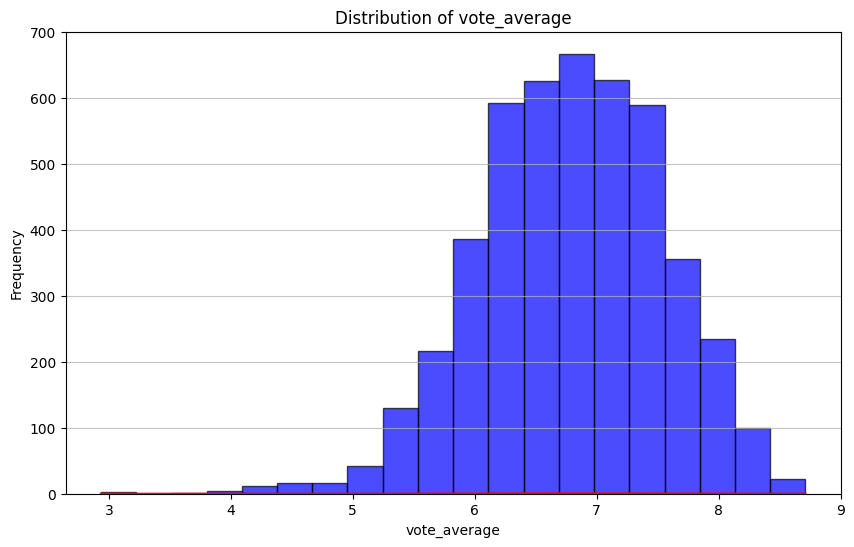

In [11]:
# python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.stats import gaussian_kde
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False
    print("scipy not available — KDE overlay will be skipped. Install with: python -m pip install scipy")

def plot_ratings(csv_path='movies_data.csv', col='vote_average', bins=20, out='ratings_distribution.png'):
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"CSV not found: `{csv_path}`")
        return

    # pick common alternatives if requested column missing
    if col not in df.columns:
        for alt in ('vote_average', 'rating', 'score', 'average_rating'):
            if alt in df.columns:
                col = alt
                break

    if col not in df.columns:
        print(f"No rating column found in `{csv_path}`; available: {', '.join(df.columns)}")

    data = df[col].dropna().values

    if len(data) == 0:
        print(f"No valid data found in `{csv_path}` for column `{col}`")
        return

    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)

    if _HAS_SCIPY:
        # Add KDE overlay
        kde = gaussian_kde(data, bw_method='scott')
        x = np.linspace(data.min(), data.max(), 100)
        plt.plot(x, kde(x), color='red')

    plt.savefig(out)
    plt.show()

if __name__ == "__main__":
    plot_ratings()

## Distribution of genres

Next, we will be looking at the frequency of genres in the dataset, to see what buckets the movies with at least a thousand ratings fit into.

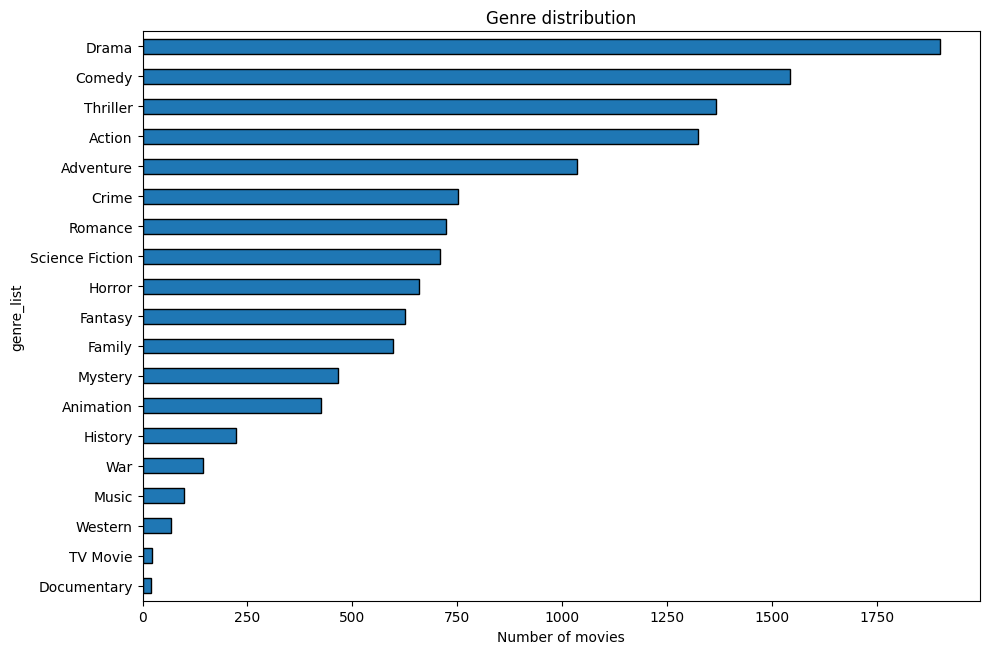

In [12]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def parse_genres(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, (list, tuple)):
        return list(cell)
    try:
        val = ast.literal_eval(cell)
        if isinstance(val, (list, tuple)):
            return [str(x).strip() for x in val]
    except Exception:
        # fallback: crude split
        s = str(cell).strip("[] ")
        items = [x.strip().strip("'\"") for x in s.split(",") if x.strip()]
        return items
    return []

def plot_genre_distribution(csv_path="movies_data.csv", out="genres_distribution.png", top_n=None):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(csv_path)
    if "genres" not in df.columns:
        print("No 'genres' column found.")
        return

    df["genre_list"] = df["genres"].apply(parse_genres)
    exploded = df["genre_list"].explode().dropna().astype(str)
    counts = exploded.value_counts()

    if counts.empty:
        print("No genres found in the dataset.")
        return

    if top_n:
        counts = counts.head(top_n)

    # horizontal bar plot sorted ascending for nicer layout
    counts = counts.sort_values()
    plt.figure(figsize=(10, max(4, len(counts) * 0.35)))
    ax = counts.plot(kind="barh", color="tab:blue", edgecolor="k")
    ax.set_xlabel("Number of movies")
    ax.set_title("Genre distribution")
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.show()

if __name__ == "__main__":
    # change csv_path or top_n as desired
    plot_genre_distribution(csv_path="movies_data.csv", out="genres_distribution.png", top_n=None)

## Most common genre combinations

Next, we will look at what genre combinations most commonly occur in the data set. 

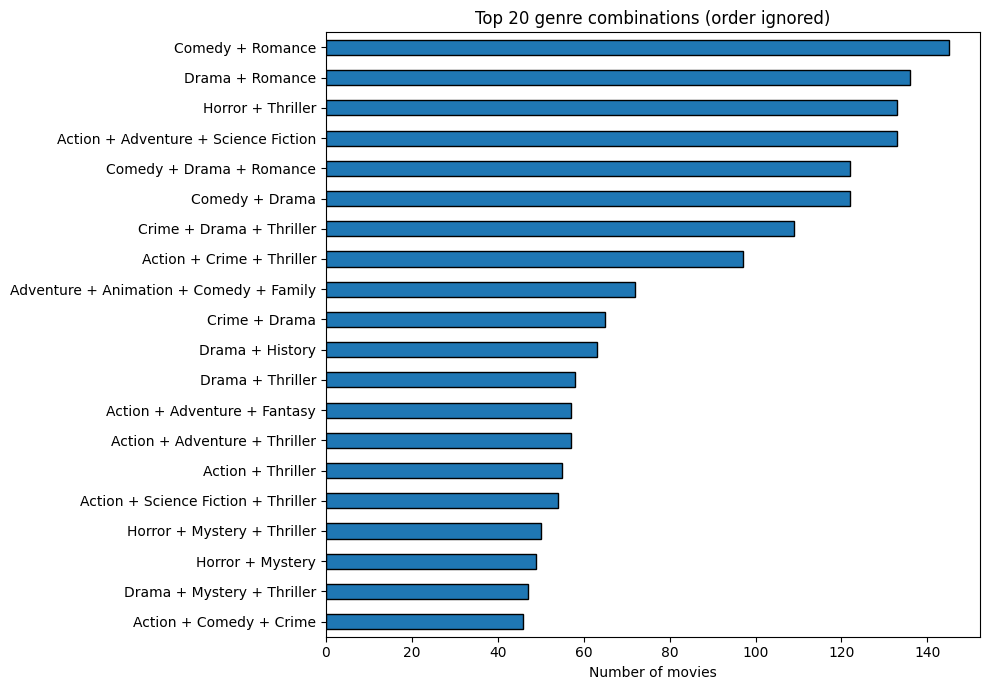

In [13]:
import ast
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


def parse_genres(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, (list, tuple)):
        return [str(x).strip() for x in cell]
    try:
        val = ast.literal_eval(cell)
        if isinstance(val, (list, tuple)):
            return [str(x).strip() for x in val]
    except Exception:
        s = str(cell).strip("[] ")
        items = [x.strip().strip("'\"") for x in s.split(",") if x.strip()]
        return items
    return []


def canonical_combo(genres):
    # remove empties, dedupe, sort so order doesn't matter
    cleaned = [g for g in (g.strip() for g in genres) if g]
    if not cleaned:
        return None
    unique = sorted(set(cleaned))
    return " + ".join(unique)  # human readable key


def plot_genre_combinations(csv_path="movies_data.csv",
                            out="genre_combinations.png",
                            top_n=20,
                            min_combo_size=None,
                            max_combo_size=None):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(csv_path)
    if "genres" not in df.columns:
        print("No 'genres' column found.")
        return

    df["genre_list"] = df["genres"].apply(parse_genres)

    combos = []
    for gl in df["genre_list"]:
        key = canonical_combo(gl)
        if not key:
            continue
        n = len(key.split(" + "))
        if min_combo_size and n < min_combo_size:
            continue
        if max_combo_size and n > max_combo_size:
            continue
        combos.append(key)

    if not combos:
        print("No genre combinations found after filtering.")
        return

    counts = Counter(combos)
    most = counts.most_common(top_n if top_n else None)
    keys, vals = zip(*most)

    # plot
    fig_height = max(4, len(keys) * 0.35)
    plt.figure(figsize=(10, fig_height))
    pd.Series(dict(most)).sort_values().plot(kind="barh", color="tab:blue", edgecolor="k")
    plt.xlabel("Number of movies")
    plt.title(f"Top {len(keys)} genre combinations (order ignored)")
    plt.tight_layout()
    plt.savefig(out, dpi=150)
    plt.show()


if __name__ == "__main__":
    # example: top 20 combinations, include single-genre entries as well
    plot_genre_combinations(csv_path="movies_data.csv",
                            out="genre_combinations.png",
                            top_n=20,
                            min_combo_size=2,
                            max_combo_size=None)

## Average rating of genres

This can be germane to group movies based on a user's taste genre-wise.

Documentary     7.340   (20)
History         7.228   (223)
War             7.223   (143)
Animation       7.140   (426)
Music           7.117   (99)
Western         7.081   (67)
Drama           7.076   (1900)
Romance         6.865   (723)
Crime           6.834   (752)
TV Movie        6.800   (22)
Family          6.778   (596)
Fantasy         6.722   (626)
Mystery         6.720   (465)
Adventure       6.716   (1036)
Comedy          6.647   (1543)
Thriller        6.641   (1367)
Action          6.631   (1323)
Science Fiction 6.607   (709)
Horror          6.390   (659)
Saved genre stats to genres_by_rating.csv
Saved plot to genres_by_rating.png


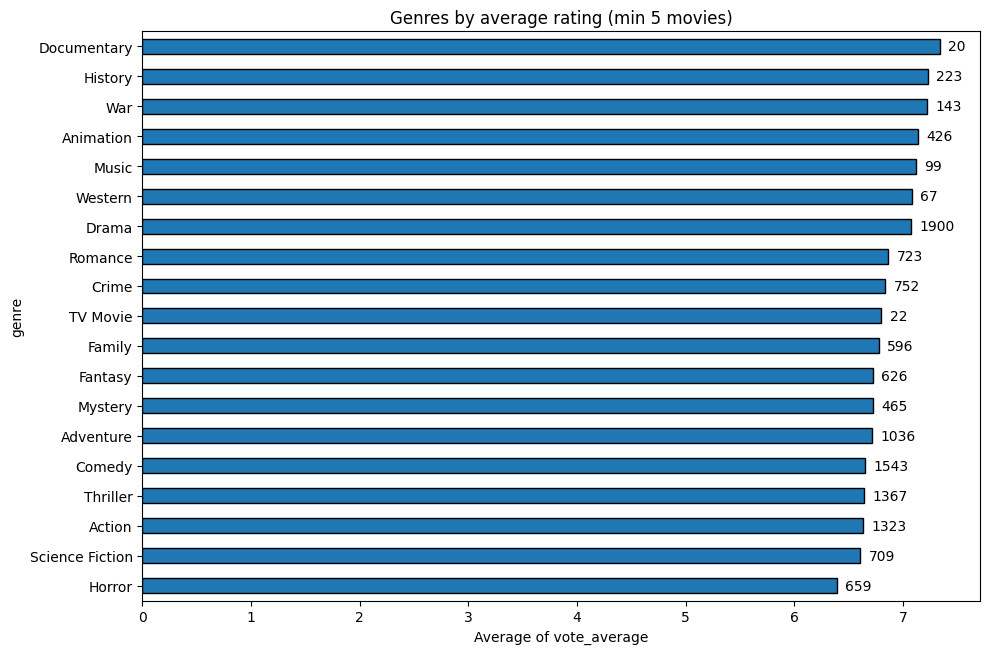

In [32]:
import argparse
import ast
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


def parse_genres(cell):
    if pd.isna(cell):
        return []
    if isinstance(cell, (list, tuple)):
        return [str(x).strip() for x in cell]
    try:
        val = ast.literal_eval(cell)
        if isinstance(val, (list, tuple)):
            return [str(x).strip() for x in val]
    except Exception:
        # fallback naive split for odd formats
        s = str(cell).strip("[] ")
        items = [x.strip().strip("'\"") for x in s.split(",") if x.strip()]
        return items
    return []


def genres_by_rating(csv_path: str = "movies_data.csv",
                     min_count: int = 5,
                     top_n: int | None = 50,
                     out_csv: str | None = None,
                     out_plot: str | None = None,
                     plot: bool = True):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(p)

    if "genres" not in df.columns:
        print("No 'genres' column found.")
        return
    if "vote_average" not in df.columns:
        print("No 'vote_average' column found.")
        return

    df["vote_average"] = pd.to_numeric(df["vote_average"], errors="coerce")
    df = df.dropna(subset=["vote_average"])

    df["genre_list"] = df["genres"].apply(parse_genres)
    exploded = df.explode("genre_list").dropna(subset=["genre_list"])
    exploded["genre_list"] = exploded["genre_list"].astype(str).str.strip()

    stats = (
        exploded.groupby("genre_list")["vote_average"]
        .agg(count="count", mean_vote="mean")
        .reset_index()
        .rename(columns={"genre_list": "genre"})
    )

    stats = stats[stats["count"] >= min_count].sort_values("mean_vote", ascending=False)

    if stats.empty:
        print("No genres meet the minimum count requirement.")
        return

    if top_n:
        stats = stats.head(top_n)

    # print results
    name_width = max(10, int(stats["genre"].str.len().max()))
    for _, row in stats.iterrows():
        print(f"{row['genre']:<{name_width}} {row['mean_vote']:5.3f}   ({int(row['count'])})")

    if out_csv:
        stats.to_csv(out_csv, index=False)
        print(f"Saved genre stats to {out_csv}")

    if plot and out_plot:
        plt.figure(figsize=(10, max(4, len(stats) * 0.35)))
        stats_sorted = stats.set_index("genre")["mean_vote"].sort_values()
        ax = stats_sorted.plot(kind="barh", color="tab:blue", edgecolor="k")
        ax.set_xlabel("Average of vote_average")
        ax.set_title(f"Genres by average rating (min {min_count} movies)")
        # annotate counts
        counts_map = stats.set_index("genre")["count"].to_dict()
        for i, (val, genre) in enumerate(zip(stats_sorted.values, stats_sorted.index)):
            ax.annotate(f"{int(counts_map[genre])}", xy=(val, i), xytext=(6, 0), textcoords="offset points", va="center")
        plt.tight_layout()
        plt.savefig(out_plot, dpi=150)
        print(f"Saved plot to {out_plot}")
        plt.show()


if __name__ == "__main__":
    ap = argparse.ArgumentParser(description="Sort genres by average of movie vote_average")
    ap.add_argument("--csv", "-c", default="movies_data.csv", help="Path to movies CSV")
    ap.add_argument("--min-count", "-m", type=int, default=5, help="Minimum number of movies per genre")
    ap.add_argument("--top", "-n", type=int, default=25, help="How many top genres to show")
    ap.add_argument("--out-csv", help="Optional CSV output path for genre stats")
    ap.add_argument("--out-plot", help="Optional plot output path (PNG). If given and --no-plot not set, plot is saved and shown")
    ap.add_argument("--no-plot", action="store_true", help="Do not create or show plot")
    args, _ = ap.parse_known_args()

    # default output paths if not provided; ensure CSV is saved and plot shown
    out_csv = args.out_csv or "genres_by_rating.csv"
    out_plot = args.out_plot or "genres_by_rating.png"

    genres_by_rating(
        csv_path=args.csv,
        min_count=args.min_count,
        top_n=args.top,
        out_csv=out_csv,
        out_plot=out_plot,
        plot=True,
        )

## Distribution of release years

For this, we look at the basic statistic of what release year the movies with 1000 or more votes fall under, as this can be germane for recommendation systems also. 

Saved histogram to release_years_hist.png


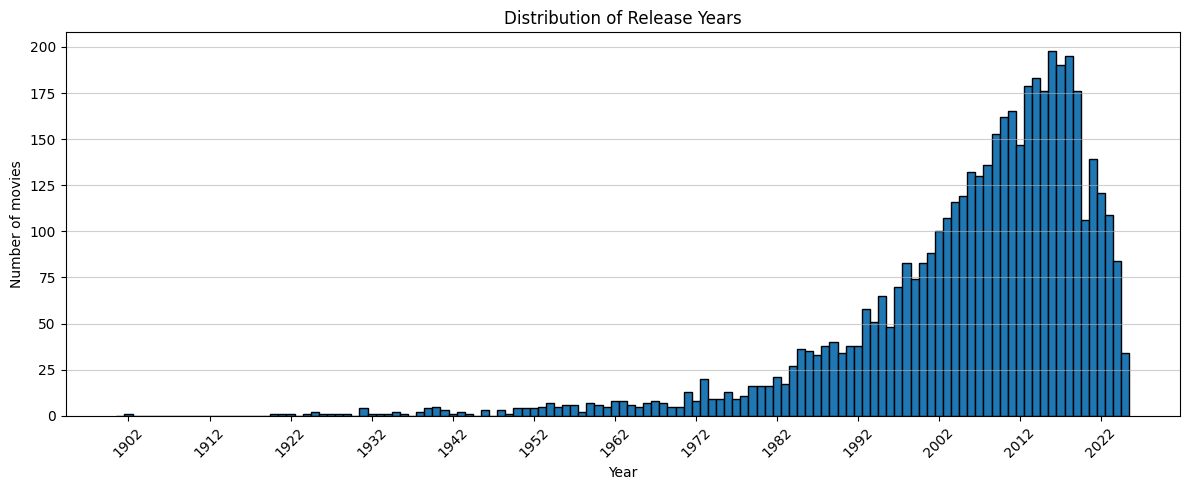

In [34]:
import argparse
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


def plot_release_years(csv_path: str = "movies_data.csv",
                       out: str = "release_years_hist.png",
                       bins: int | None = None):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(p)
    if "release_date" not in df.columns and "release_year" not in df.columns:
        print("No 'release_date' or 'release_year' column found.")
        return

    if "release_year" in df.columns:
        years = pd.to_numeric(df["release_year"], errors="coerce").dropna().astype(int)
    else:
        # robust parse of release_date, tolerate empty/invalid values
        dates = pd.to_datetime(df["release_date"], errors="coerce")
        years = dates.dt.year.dropna().astype(int)

    if years.empty:
        print("No valid release years found in the dataset.")
        return

    # choose integer-per-year bins by default
    if bins is None:
        year_min = int(years.min())
        year_max = int(years.max())
        bins = list(range(year_min - 1, year_max + 2))  # one bin per year

    plt.figure(figsize=(12, 5))
    plt.hist(years, bins=bins, color="tab:blue", edgecolor="k", align="left")
    plt.title("Distribution of Release Years")
    plt.xlabel("Year")
    plt.ylabel("Number of movies")
    plt.grid(axis="y", alpha=0.6)

    # nicer x ticks: every N years depending on span
    span = years.max() - years.min()
    step = 1 if span <= 20 else (5 if span <= 100 else 10)
    xticks = list(range(years.min(), years.max() + 1, step))
    plt.xticks(xticks, rotation=45)

    plt.tight_layout()
    plt.savefig(out, dpi=150)
    print(f"Saved histogram to {out}")
    plt.show()

if __name__ == "__main__":
    ap = argparse.ArgumentParser(description="Plot histogram of movie release years.")
    ap.add_argument("--csv", "-c", default="movies_data.csv", help="Path to movies CSV")
    ap.add_argument("--out", "-o", default="release_years_hist.png", help="Output image path")
    ap.add_argument("--bins", "-b", type=int, default=None, help="Number of bins (optional)")
    args, _ = ap.parse_known_args()

    plot_release_years(csv_path=args.csv, out=args.out, bins=args.bins)

## Highest rated release years

As some viewers believe the 70s to be the best decade for cinema, the highest rated release years can also be a relevant group to be used in the recommendation system. 

Saved CSV to mean_vote_by_year.csv
 1. 1991   6.991   (38)
 2. 2020   6.990   (106)
 3. 1988   6.985   (38)
 4. 2022   6.966   (121)
 5. 2023   6.956   (109)
 6. 1993   6.953   (58)
 7. 1995   6.952   (65)
 8. 1992   6.947   (38)
 9. 2021   6.936   (139)
10. 1990   6.924   (34)
11. 1994   6.913   (51)
12. 2025   6.903   (34)
13. 1985   6.893   (36)
14. 1986   6.888   (35)
15. 1987   6.881   (33)
16. 1999   6.877   (74)
17. 2019   6.870   (176)
18. 2024   6.859   (84)
19. 1998   6.833   (83)
20. 2000   6.805   (83)
21. 1997   6.785   (70)
22. 1989   6.775   (40)
23. 2004   6.751   (116)
24. 2007   6.737   (130)
25. 2001   6.735   (88)
Saved CSV to years_by_rating.csv
Saved plot to years_by_rating.png


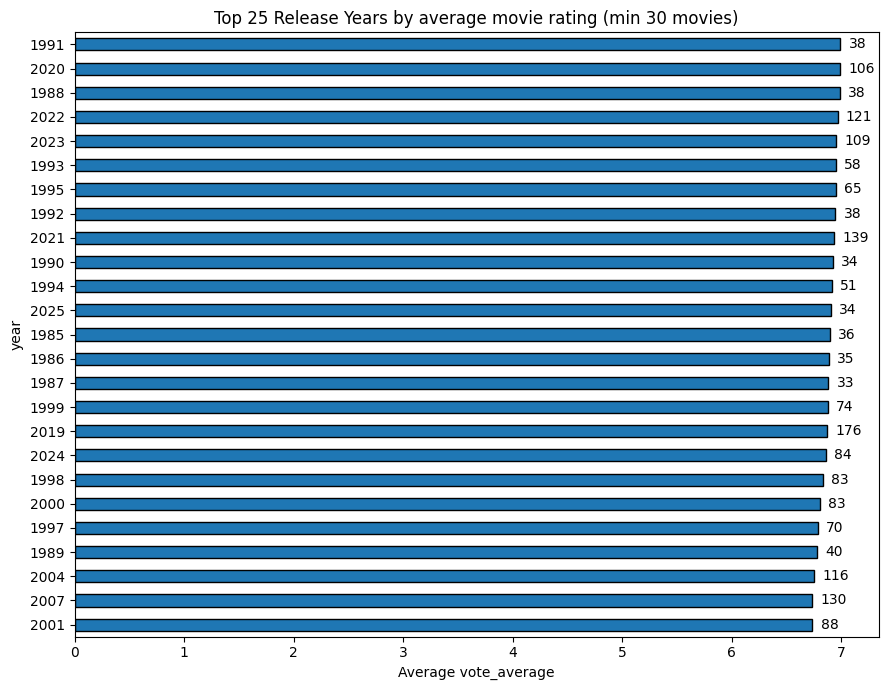

In [36]:
import argparse
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


def top_years_by_rating(csv_path: str = "movies_data.csv",
                        top_n: int = 25,
                        min_count: int = 1,
                        out_csv: str | None = "years_by_rating.csv",
                        out_plot: str | None = "years_by_rating.png",
                        plot: bool = True):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(p)

    if "vote_average" not in df.columns:
        print("No 'vote_average' column found.")
        return

    # extract year (prefer explicit column)
    if "release_year" in df.columns:
        years = pd.to_numeric(df["release_year"], errors="coerce")
    else:
        years = pd.to_datetime(df.get("release_date", None), errors="coerce").dt.year

    df = df.copy()
    df["release_year_parsed"] = years
    df["vote_average"] = pd.to_numeric(df["vote_average"], errors="coerce")
    df = df.dropna(subset=["release_year_parsed", "vote_average"])

    if df.empty:
        print("No valid rows with both release year and vote_average.")
        return

    year_stats = (
        df.groupby(df["release_year_parsed"].astype(int))["vote_average"]
        .agg(mean_vote="mean", count="count")
        .reset_index()
        .rename(columns={"release_year_parsed": "year"})
    )

    # save the full table for reference
    year_stats.to_csv("mean_vote_by_year.csv", index=False)
    print("Saved CSV to mean_vote_by_year.csv")

    # require minimum number of movies per year, then pick top_n years by mean_vote
    filtered = year_stats[year_stats["count"] >= min_count]
    if filtered.empty:
        print("No years meet the filter criteria.")
        return

    top_years = filtered.sort_values("mean_vote", ascending=False)
    if top_n:
        top_years = top_years.head(top_n).reset_index(drop=True)
    else:
        top_years = top_years.reset_index(drop=True)

    # print results: rank, year, mean, (count)
    for i, row in top_years.iterrows():
        print(f"{i+1:2d}. {int(row['year']):4d}   {row['mean_vote']:5.3f}   ({int(row['count'])})")

    if out_csv:
        top_years.to_csv(out_csv, index=False)
        print(f"Saved CSV to {out_csv}")

    if plot and out_plot:
        # horizontal bar chart of the top years by average rating
        plot_series = top_years.set_index("year")["mean_vote"].sort_values()
        plt.figure(figsize=(9, max(4, len(plot_series) * 0.28)))
        ax = plot_series.plot(kind="barh", color="tab:blue", edgecolor="k")
        ax.set_xlabel("Average vote_average")
        ax.set_title(f"Top {len(top_years)} Release Years by average movie rating (min {min_count} movies)")
        counts_map = top_years.set_index("year")["count"].to_dict()
        for i, (val, year) in enumerate(zip(plot_series.values, plot_series.index)):
            ax.annotate(f"{int(counts_map[year])}", xy=(val, i), xytext=(6, 0), textcoords="offset points", va="center")
        plt.tight_layout()
        plt.savefig(out_plot, dpi=150)
        print(f"Saved plot to {out_plot}")
        plt.show()


if __name__ == "__main__":
    ap = argparse.ArgumentParser(description="Top release years by average of movie vote_average")
    ap.add_argument("--csv", "-c", default="movies_data.csv", help="Path to movies CSV")
    ap.add_argument("--top", "-n", type=int, default=25, help="How many top years to show")
    ap.add_argument("--min-count", "-m", type=int, default=1, help="Minimum number of movies in a year")
    ap.add_argument("--out-csv", help="CSV output path (default: years_by_rating.csv)", default="years_by_rating.csv")
    ap.add_argument("--out-plot", help="Plot output path (default: years_by_rating.png)", default="years_by_rating.png")
    ap.add_argument("--no-plot", action="store_true", help="Do not create or show plot")
    args, _ = ap.parse_known_args()

    out_csv = args.out_csv or "years_by_rating.csv"
    out_plot = args.out_plot or "years_by_rating.png"

    top_years_by_rating(
        csv_path=args.csv,
        top_n=args.top,
        min_count=30,
        out_csv=out_csv,
        out_plot=out_plot,
        plot=True,
    )

## Most featured directors

As some directors are what the industry would call auteurs, their names alone could help forming groups later on which could also become useful in recommendation systems. 

Steven Spielberg       33
Ridley Scott           26
Clint Eastwood         25
Martin Scorsese        21
Robert Zemeckis        19
Ron Howard             18
Woody Allen            17
Robert Rodriguez       17
Tim Burton             17
Guy Ritchie            16
Joel Coen              16
Michael Bay            15
Alfred Hitchcock       15
Luc Besson             14
Steven Soderbergh      14
Richard Donner         14
John Carpenter         14
M. Night Shyamalan     14
David Cronenberg       13
Antoine Fuqua          13
Shawn Levy             13
Sam Raimi              13
Tony Scott             13
Oliver Stone           12
Danny Boyle            12
Saved bar chart to top_directors.png


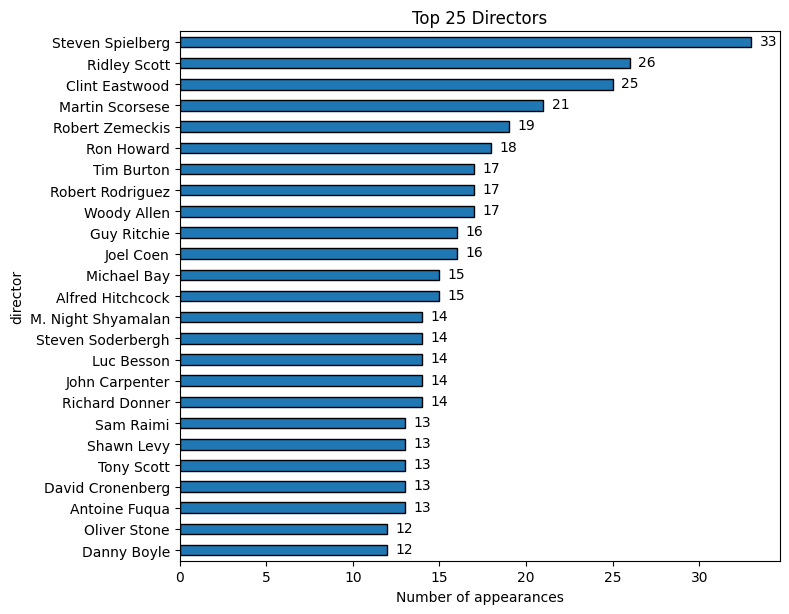

In [1]:
import argparse
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


def top_directors(csv_path: str = "movies_data.csv",
                  top_n: int = 100,
                  plot: bool = True,
                  out: str = "top_directors.png"):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(p)

    if "director" not in df.columns:
        print("No 'director' column found.")
        return

    # normalize director names, treat NaN/empty as '<unknown>'
    names = df["director"].fillna("<unknown>").astype(str).str.strip()
    names = names.replace({"": "<unknown>"})
    counts = names.value_counts()

    top = counts.head(top_n)

    # print with counts to the right
    name_width = max(20, min(60, max((len(n) for n in top.index), default=20)))
    for name, cnt in top.items():
        print(f"{name:<{name_width}} {cnt:>4}")

    if plot and not top.empty:
        plt.rcParams.update({"figure.autolayout": True})
        fig, ax = plt.subplots(figsize=(8, max(4, len(top) * 0.25)))
        top.sort_values().plot(kind="barh", ax=ax, color="tab:blue", edgecolor="k")
        ax.set_xlabel("Number of appearances")
        ax.set_title(f"Top {len(top)} Directors")
        # annotate counts to the right of each bar
        for i, (val, name) in enumerate(zip(top.sort_values().values, top.sort_values().index)):
            ax.annotate(str(val), xy=(val, i), xytext=(6, -2), textcoords="offset points")
        fig.savefig(out, dpi=150)
        print(f"Saved bar chart to {out}")
        plt.show()


if __name__ == "__main__":
    ap = argparse.ArgumentParser(description="Show top directors and counts from movies CSV")
    ap.add_argument("--csv", "-c", default="movies_data.csv", help="Path to movies CSV")
    ap.add_argument("--top", "-n", type=int, default=25, help="How many top directors to show")
    ap.add_argument("--no-plot", action="store_true", help="Do not display or save plot")
    ap.add_argument("--out", "-o", default="top_directors.png", help="Plot output path")
    args, _ = ap.parse_known_args()

    top_directors(csv_path=args.csv, top_n=args.top, plot=not args.no_plot, out=args.out)

## Highest rated directors

Some directors are more adored by audiences than others and therefore, directors with high ratings are also germane for recommendation systems. 

 1. Akira Kurosawa       8.208   (6)
 2. Charlie Chaplin      8.194   (5)
 3. Sergio Leone         8.112   (6)
 4. Billy Wilder         8.069   (6)
 5. Hayao Miyazaki       7.940   (12)
 6. Stanley Kubrick      7.873   (12)
 7. Makoto Shinkai       7.851   (5)
 8. Quentin Tarantino    7.843   (11)
 9. Christopher Nolan    7.830   (12)
10. Mel Gibson           7.763   (5)
11. Alfred Hitchcock     7.755   (15)
12. Denis Villeneuve     7.697   (8)
13. Sidney Lumet         7.664   (6)
14. James Cameron        7.662   (8)
15. Jay Oliva            7.656   (5)
16. Francis Ford Coppola 7.603   (9)
17. Peter Jackson        7.580   (10)
18. Alfonso Cuarón       7.568   (6)
19. Peter Weir           7.543   (5)
20. Alan Parker          7.529   (5)
21. Martin Scorsese      7.522   (21)
22. Park Chan-wook       7.498   (7)
23. Bong Joon Ho         7.495   (7)
24. Pedro Almodóvar      7.486   (6)
25. Brad Bird            7.397   (6)
Saved plot to top_directors_by_rating.png


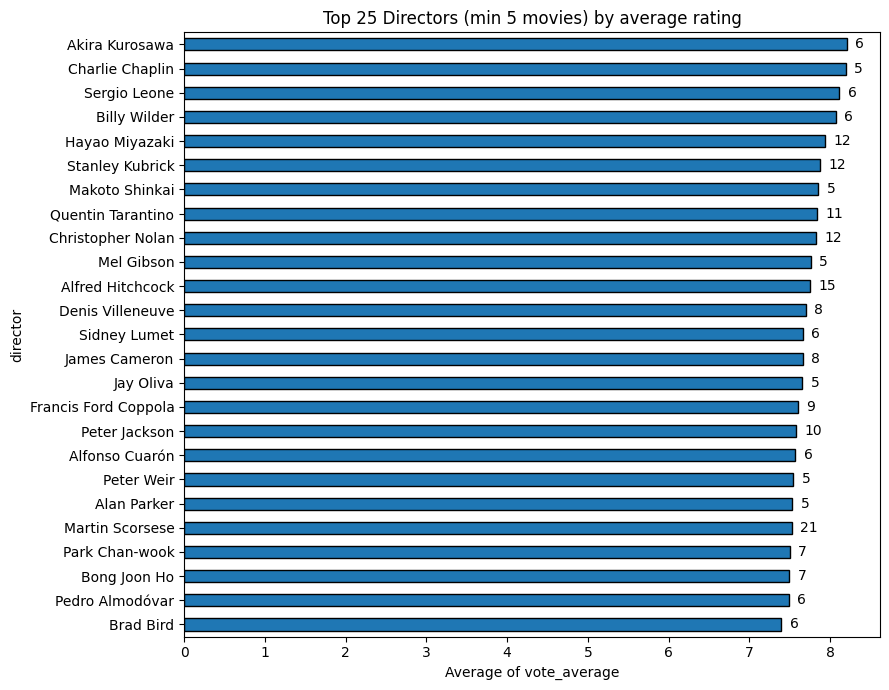

In [31]:
import argparse
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


def top_directors_by_rating(csv_path: str = "movies_data.csv",
                            top_n: int = 25,
                            min_count: int = 5,
                            out: str = "top_directors_by_rating.png",
                            exclude_unknown: bool = True):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(p)

    if "director" not in df.columns:
        print("No 'director' column found.")
        return
    if "vote_average" not in df.columns:
        print("No 'vote_average' column found.")
        return

    # normalize and drop missing ratings
    df["director"] = df["director"].fillna("<unknown>").astype(str).str.strip()
    df["vote_average"] = pd.to_numeric(df["vote_average"], errors="coerce")
    df = df.dropna(subset=["vote_average"])

    if exclude_unknown:
        df = df[df["director"] != "<unknown>"]

    # aggregate: count of movies and mean of vote_average per director
    stats = (
        df.groupby("director", sort=False)["vote_average"]
        .agg(count="count", mean_vote="mean")
        .reset_index()
    )

    # filter by minimum appearances and sort by mean vote desc
    stats = stats[stats["count"] >= min_count].sort_values("mean_vote", ascending=False)

    top = stats.head(top_n).reset_index(drop=True)

    if top.empty:
        print("No directors meeting the filter criteria.")
        return

    # printing: ranked list, mean rating and appearances to the right
    name_width = max(20, min(60, int(top["director"].str.len().max())))
    for i, row in top.iterrows():
        rank = i + 1
        name = row["director"]
        mean = row["mean_vote"]
        cnt = int(row["count"])
        print(f"{rank:2d}. {name:<{name_width}} {mean:5.3f}   ({cnt})")


    plt.rcParams.update({"figure.autolayout": True})
    fig, ax = plt.subplots(figsize=(9, max(4, len(top) * 0.28)))
    ax = top.set_index("director")["mean_vote"].sort_values().plot(
    kind="barh", color="tab:blue", edgecolor="k", ax=ax
    )
    ax.set_xlabel("Average of vote_average")
    ax.set_title(f"Top {len(top)} Directors (min {min_count} movies) by average rating")
    # annotate count to right of each bar
    means_sorted = top.set_index("director")["mean_vote"].sort_values()
    for i, (director, mean_val) in enumerate(means_sorted.items()):
        cnt = int(top[top["director"] == director]["count"].iloc[0])
        ax.annotate(f"{cnt}", xy=(mean_val, i), xytext=(6, 0), textcoords="offset points", va="center")
    fig.savefig(out, dpi=150)
    print(f"Saved plot to {out}")
    plt.show()


if __name__ == "__main__":
    ap = argparse.ArgumentParser(description="Top directors by average of average ratings")
    ap.add_argument("--csv", "-c", default="movies_data.csv", help="Path to movies CSV")
    ap.add_argument("--top", "-n", type=int, default=25, help="How many top directors to show")
    ap.add_argument("--min-count", "-m", type=int, default=5, help="Minimum number of movies for a director")
    ap.add_argument("--out", "-o", default="top_directors_by_rating.png", help="Plot output path")
    ap.add_argument("--include-unknown", action="store_true", help="Include '<unknown>' director entries")
    args, _ = ap.parse_known_args()

    top_directors_by_rating(
        csv_path=args.csv,
        top_n=args.top,
        min_count=args.min_count,
        out=args.out,
        exclude_unknown=not args.include_unknown,
    )

# Distribution of original languages

Some users may have a preference for language which may become useful in grouping for recommendation algorithms.

Saved language counts to languages_by_count.csv
Saved plot to languages_distribution.png


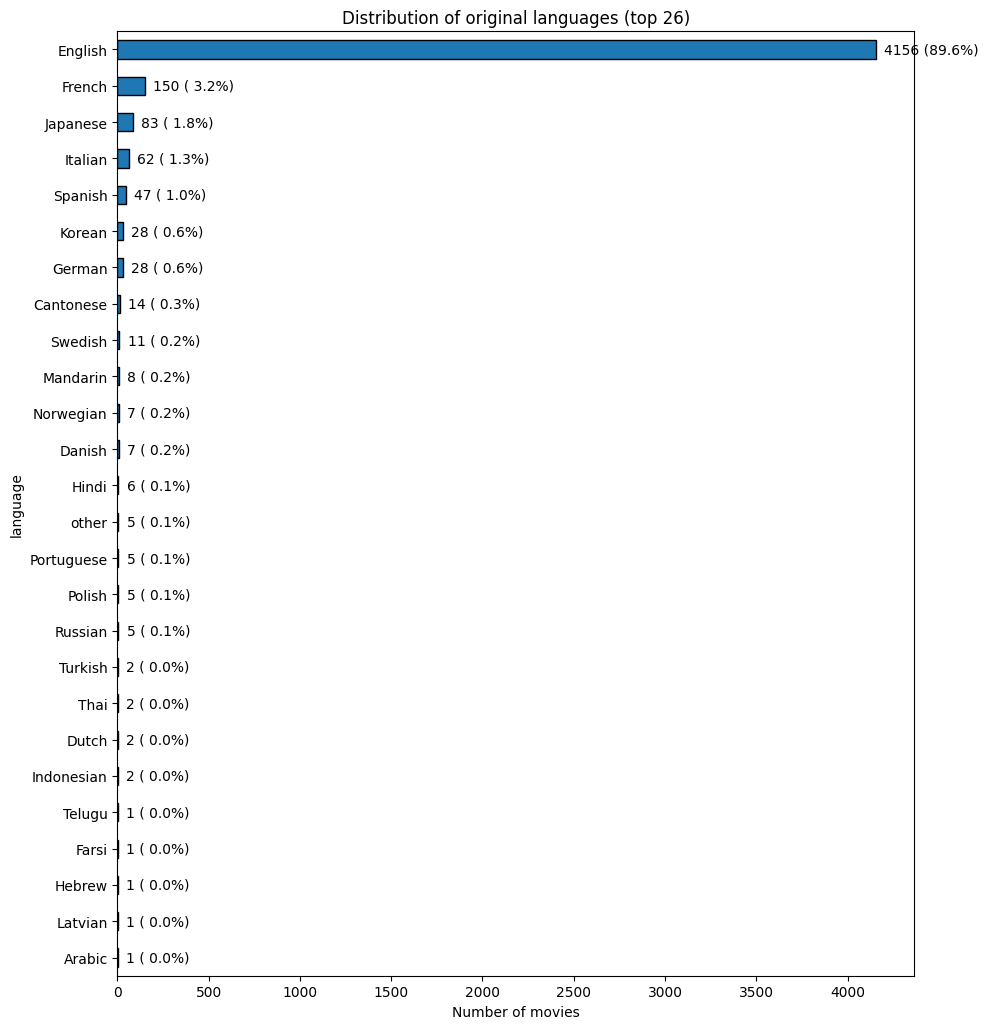

In [6]:
import argparse
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


LANGUAGE_NAMES = {
    "en": "English",
    "ja": "Japanese",
    "fr": "French",
    "it": "Italian",
    "es": "Spanish",
    "de": "German",
    "pt": "Portuguese",
    "hi": "Hindi",
    "ko": "Korean",
    "cn": "Cantonese",
    "ru": "Russian",
    "tr": "Turkish",
    "ar": "Arabic",
    "fa": "Farsi",
    "sv": "Swedish",
    "nl": "Dutch",
    "pl": "Polish",
    "da": "Danish",
    "no": "Norwegian",
    "fi": "Finnish",
    "he": "Hebrew",
    "el": "Greek",
    "th": "Thai",
    "id": "Indonesian",
    "vi": "Vietnamese",
    "cs": "Czech",
    "hu": "Hungarian",
    "ro": "Romanian",
    "bg": "Bulgarian",
    "uk": "Ukrainian",
    "sr": "Serbian",
    "hr": "Croatian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "et": "Estonian",
    "ms": "Malay",
    "ta": "Tamil",
    "te": "Telugu",
    "ml": "Malayalam",
    "kn": "Kannada",
    "mr": "Marathi",
    "bn": "Bengali",
    "gu": "Gujarati",
    "pa": "Punjabi",
    "or": "Odia",
    "as": "Assamese",
    "ne": "Nepali",
    "si": "Sinhala",
    "my": "Burmese",
    "km": "Khmer",
    "lo": "Lao",
    "am": "Amharic",
    "sw": "Swahili",
    "zh": "Mandarin",
    "xx": "No Language",  # sometimes used to indicate no spoken language
    # add more as needed
}


def plot_language_distribution(csv_path: str = "movies_data.csv",
                               out: str = "languages_distribution.png",
                               out_csv: str | None = "languages_by_count.csv",
                               top_n: int | None = 25,
                               plot: bool = True):
    p = Path(csv_path)
    if not p.exists():
        print(f"CSV not found: {csv_path}")
        return

    df = pd.read_csv(p)
    if "original_language" not in df.columns:
        print("No 'original_language' column found.")
        return

    langs = df["original_language"].fillna("<unknown>").astype(str)
    counts = langs.value_counts()

    if counts.empty:
        print("No language data present.")
        return

    if top_n and len(counts) > top_n:
        top = counts.head(top_n)
        other = counts.iloc[top_n:].sum()
        top.loc["other"] = other
        counts = top

    # human readable labels
    labels = [LANGUAGE_NAMES.get(code, code) for code in counts.index]
    stats = pd.DataFrame({
        "code": counts.index,
        "language": labels,
        "count": counts.values
    })
    stats["percent"] = stats["count"] / stats["count"].sum() * 100

    if out_csv:
        stats.to_csv(out_csv, index=False)
        print(f"Saved language counts to {out_csv}")

    if plot:
        plt.figure(figsize=(10, max(4, len(stats) * 0.4)))
        series = stats.set_index("language")["count"].sort_values()
        ax = series.plot(kind="barh", color="tab:blue", edgecolor="k")
        ax.set_xlabel("Number of movies")
        ax.set_title(f"Distribution of original languages (top {len(stats)})")
        # annotate with count and percent
        for i, (lang, val) in enumerate(zip(series.index, series.values)):
            pct = stats.loc[stats["language"] == lang, "percent"].iloc[0]
            ax.annotate(f"{int(val)} ({pct:4.1f}%)", xy=(val, i), xytext=(6, 0),
                        textcoords="offset points", va="center")
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        print(f"Saved plot to {out}")
        plt.show()


if __name__ == "__main__":
    ap = argparse.ArgumentParser(description="Plot distribution of original languages")
    ap.add_argument("--csv", "-c", default="movies_data.csv", help="Path to movies CSV")
    ap.add_argument("--out", "-o", default="languages_distribution.png", help="Plot output path")
    ap.add_argument("--out-csv", default="languages_by_count.csv", help="Optional CSV of counts")
    ap.add_argument("--top", "-n", type=int, default=25, help="How many top languages to show (others aggregated)")
    ap.add_argument("--no-plot", action="store_true", help="Do not show or save plot")
    args, _ = ap.parse_known_args()

    out_csv = args.out_csv or "languages_by_count.csv"
    out_plot = args.out or "languages_distribution.png"

    plot_language_distribution(csv_path=args.csv,
                               out=out_plot,
                               out_csv=out_csv,
                               top_n=args.top,
                               plot=True)